# Mx_Seahorse: Correction

SpaceM datasets are usually stored as annotated data-matrices, separately for individual wells. With this notebooks, these individual files are corrected for ion suppression on the pixel-level and then deconvoluted to cell-level. All resulting files are saved separately by well to the target_path and the impact of the correction briefly shown for visual inspection.

In [1]:
import os
import platform
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import statistics as st
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import statsmodels.formula.api as smf
import seaborn as sns
import re
from importlib import reload
import json
import sys
sys.path.append('/home/mklein/spacem')
sys.path.append('/home/mklein/FDA_project')

from src.correction import (add_normalization_factors, 
                            correct_quantile_inplace,
                            deconvolution_spacem,
                            get_overlap_data,
                            add_overlap_matrix_spacem
                           )
from src import const 
from SpaceM.lib.modules import (
    overlap_analysis,
    single_cell_analysis_normalization
)

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

The original data lies on the groups shared data storage. Corrected files will be saved in a separate location, preserving the well-specific folder structure.

In [2]:
if platform.system() == "Darwin":
    source_path = '/Volumes/alexandr/smenon/2022-07-13_Glioblastoma/processed_files'
    target_path = '/Volumes/mklein/FDA_project/data/Lx_Glioblastoma'
else:
    source_path = '/g/alexandr/smenon/2022-07-13_Glioblastoma/processed_files'
    target_path = '/home/mklein/FDA_project/data/Lx_Glioblastoma'
    
# TODO: implement topX reference ion pool.
reference_pool = {'top': 10}
deconv_default_min_overlap = 0.0

In [3]:
# Parameters
source_path = "/home/mklein/Raw Data/220412_Luisa_ScSeahorse_SpaceM"
target_path = "/home/mklein/FDA_project/data/Mx_Seahorse"
condition_name = "treatment"
well_name = "rowcol"
analysis_path = "/home/mklein/FDA_project/analysis/Mx_Seahorse"
notebooks = [
    "pipeline_01_correction.ipynb",
    "pipeline_02_processing.ipynb",
    "pipeline_03_evaluation.ipynb",
]
project = "Mx_Seahorse"


In [4]:
samples = []
for dirpath, dirnames, filenames in os.walk(source_path):
        if 'analysis' in dirnames:
            samples.append(re.sub(source_path+'/?', '', dirpath))
samples

['A2',
 'A3',
 'B1',
 'B3',
 'B4',
 'C1',
 'D1',
 'E1',
 'E2',
 'E3',
 'E4',
 'F2',
 'F3',
 'F4',
 'G1',
 'G4',
 'H3',
 'H4',
 'J2']

In [5]:
files = {
        'config': '../config.json',
        'sm_matrix': 'ablation_mark_analysis/spatiomolecular_adata.h5ad',
        'overlap_regions': 'overlap_analysis2/overlap.regions.csv',
        'mark_regions': 'overlap_analysis2/ablation_mark.regions.csv',
        'cell_regions': 'overlap_analysis2/cell.regions.csv',
        'cell_sm_matrix': 'single_cell_analysis/spatiomolecular_adata.h5ad',
    }

In [6]:
def assign_average_tpo(am_adata, overlap_data, min_overlap, method=np.mean):
    if min_overlap is None:
        min_overlap = 0
    
    overlap = overlap_data.overlap_regions
    overlap['am_id'] = overlap['am_id'].astype(str)
    overlap['cell_id'] = overlap['cell_id'].astype(str)
    merged_df = pd.merge(overlap[['am_id', 'cell_id']], am_adata.obs[const.TPO], left_on='am_id', right_index=True)
    merged_df = merged_df[merged_df[const.TPO] >= min_overlap]
    
    mean_df = merged_df[['cell_id', 'correction_total_pixel_overlap']].groupby('cell_id', group_keys=False).agg(method)
#     mean_df = merged_df[['cell_id', 'correction_total_pixel_overlap']].groupby('cell_id', group_keys=False).agg(lambda x: method(x))
    return mean_df[const.TPO]

In [7]:
def correct_sample_spacem(sample):
    
    sample_path = os.path.join(source_path, sample, "analysis")
    sample = re.sub('/', '_', sample)
    
    if not os.path.exists(os.path.join(target_path, sample)):
        os.makedirs(os.path.join(target_path, sample))

    # get appropriate file paths for the processed well
    project_files = {k: os.path.join(sample_path, v) for k, v in files.items()}

    if os.path.exists(project_files['config']):
        with open(project_files['config']) as json_file:
            data = json.load(json_file)
        deconv_info = data['single_cell_analysis']
        if deconv_info['ablation_marks_min_overlap_ratio'] is None:
            deconv_info['ablation_marks_min_overlap_ratio'] = deconv_default_min_overlap
    else:
        deconv_info = None
        print('No well config file found. Using default deconvolution parameters.')
    # load required files
    cell_regions = pd.read_csv(project_files['cell_regions'])
    mark_regions = pd.read_csv(project_files['mark_regions'])
    overlap_regions = pd.read_csv(project_files['overlap_regions'])
    
    sm_matrix = sc.read(os.path.join(sample_path, files['sm_matrix']))
    cell_sm_matrix = sc.read(os.path.join(sample_path, files['cell_sm_matrix']))
       
    add_overlap_matrix_spacem(sm_matrix, cell_regions, mark_regions, overlap_regions)
    
    add_normalization_factors(adata=sm_matrix, method=st.median)

    # perform the actual quantile regression
    corr_sm_matrix = correct_quantile_inplace(adata=sm_matrix, 
        reference_ions=sm_matrix.var_names, 
        correct_intersect = True,
        n_jobs=5)
    
    # perform pixel-cell-deconvolution
    overlap_data = get_overlap_data(cell_regions, mark_regions, overlap_regions)
    corr_cell_sm_matrix = deconvolution_spacem(adata=corr_sm_matrix, 
        overlap_data=overlap_data,
        raw_adata=cell_sm_matrix,
        deconvolution_params=deconv_info)
    gen_cell_sm_matrix = deconvolution_spacem(adata=sm_matrix,
        overlap_data=overlap_data,
        raw_adata=cell_sm_matrix,
        deconvolution_params=deconv_info)
    
    # hand over TPOs to spatiomolecular matrix for downstream analysis
    min_overlap = deconv_info['ablation_marks_min_overlap_ratio']
    corr_cell_sm_matrix.obs['list_TPO'] = assign_average_tpo(sm_matrix, overlap_data, min_overlap, method=lambda x: ";".join(x.astype(str)))
    gen_cell_sm_matrix.obs['list_TPO'] = assign_average_tpo(sm_matrix, overlap_data, min_overlap, method=lambda x: ";".join(x.astype(str)))
    
    # write the generated files to the dedicated project location.
    corr_sm_matrix.write(os.path.join(target_path, sample, 'am_spatiomolecular_adata_corrected.h5ad'))
    sm_matrix.write(os.path.join(target_path, sample, 'am_spatiomolecular_adata.h5ad'))
    corr_cell_sm_matrix.write(os.path.join(target_path, sample, 'cells_spatiomolecular_adata_corrected.h5ad'))
    cell_sm_matrix.write(os.path.join(target_path, sample, 'cells_spatiomolecular_adata_spacem.h5ad'))
    gen_cell_sm_matrix.write(os.path.join(target_path, sample, 'cells_spatiomolecular_adata.h5ad'))
    
    return (sample, cell_sm_matrix, corr_cell_sm_matrix, sm_matrix, corr_sm_matrix, deconv_info)

This is the actual correction pipeline.

In [8]:
adata_list = Parallel(n_jobs=7)(delayed(correct_sample_spacem)(sample) for sample in tqdm(samples))
# adata_list = [correct_sample_spacem(sample) for sample in tqdm(['I4'])]


  0%|                                                                                                                                        | 0/19 [00:00<?, ?it/s]


 37%|███████████████████████████████████████████████▏                                                                                | 7/19 [00:00<00:00, 57.03it/s]

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



 37%|███████████████████████████████████████████████▏                                                                                | 7/19 [00:19<00:00, 57.03it/s]

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



 74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 14/19 [00:45<00:18,  3.79s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:45<00:00,  2.38s/it]

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [9]:
# reshape data for immediate analysis
am_adata_dict = {item[0]: item[3] for item in adata_list}
am_adata_cor_dict = {item[0]: item[4] for item in adata_list}
adata_dict = {item[0]: item[1] for item in adata_list}
adata_cor_dict = {item[0]: item[2] for item in adata_list}

am_adata = ad.concat(am_adata_dict, label='well', index_unique="_", merge="first")
am_adata_cor = ad.concat(am_adata_cor_dict, label='well', index_unique="_", merge='first')
adata = ad.concat(adata_dict, label='well', index_unique="_", merge="first")
adata_cor = ad.concat(adata_cor_dict, label='well', index_unique="_", merge="first")

deconv_dict = {item[0]: item[5] for item in adata_list}
deconv_table = pd.DataFrame(deconv_dict).T
deconv_table

,cell_normalization_method,ablation_marks_min_overlap_ratio,fluorescence_channels,cell_ion_max_correlation_distance,ions_of_interest
A2,weighted_by_overlap_and_sampling_area,0.0,[DAPI],None,[]
A3,weighted_by_overlap_and_sampling_area,0.0,[DAPI],None,[]
B1,weighted_by_overlap_and_sampling_area,0.0,[DAPI],None,[]
B3,weighted_by_overlap_and_sampling_area,0.0,[DAPI],None,[]
B4,weighted_by_overlap_and_sampling_area,0.0,[DAPI],None,[]
C1,weighted_by_overlap_and_sampling_area,0.0,[DAPI],None,[]
D1,weighted_by_overlap_and_sampling_area,0.0,[DAPI],None,[]
E1,weighted_by_overlap_and_sampling_area,0.0,[DAPI],None,[]
E2,weighted_by_overlap_and_sampling_area,0.0,[DAPI],None,[]
E3,weighted_by_overlap_and_sampling_area,0.0,[DAPI],None,[]


Every analysed pixel is characterized by its total overlap with cellular regions. The raw data shows no clear association between this overlap and acquired ion intensities. However, after the ion suppression correction, pixels with smaller overlap clearly have lower corresponding intensities (only shown for one metabolite). 

In [10]:
import warnings
warnings.filterwarnings('ignore')
from src.correction import normalize_proportion_ratios
       

def plot_all_wells(adata, ions=None, row='well', x=const.TPO, ratio=True):
    
    top_wells = list(set(adata.obs[row]))[:5]
    adata = adata[adata.obs[row].isin(top_wells)]
    
    if ions is None and not ratio:
        ions = list(adata.var_names[:5])
    elif ions is None and ratio:
        ions = list(normalize_proportion_ratios(intensities_ad=adata).to_df().sum().sort_values().tail().index)
        
    yscale = 'intensity'
    if ratio:
        adata = normalize_proportion_ratios(intensities_ad=adata)
        yscale = 'intensity_proportion_ratio'

    plot_df = sc.get.obs_df(adata, keys=[row, x] + ions).melt(id_vars=[row, x], var_name='ion', value_name=yscale)
    plot_df= plot_df[plot_df[yscale] > 0]
    
    if ratio:
        plot_df[yscale] = np.log10(plot_df[yscale])
        plot_df[x] = np.log10(plot_df[x])
       
    graph = sns.FacetGrid(plot_df, row=row, col='ion', sharey=False, margin_titles=True)
    graph.map(sns.histplot, x, yscale, bins=50, stat='proportion').add_legend()
        
    params = []

    for well in list(set(plot_df[row])):
        for i in ions:
            q_df = plot_df[(plot_df['ion'] == i) & (plot_df[row] == well)]
            if len(q_df) == 0:
                params[i] = {'Intercept': np.nan, x: np.nan}
                continue
            model = smf.quantreg(yscale+' ~ '+x, q_df)
            qrmodel = model.fit(q=0.5)
            params.append({'ion': i, row: well, 'Intercept': qrmodel.params[0], x: qrmodel.params[1]})
    
        
    return pd.DataFrame(params).sort_values(['ion', row]).set_index(['ion', row])
    
def compare_pre_post_correction(adata, adata_cor, ions=None, ratio=True):
    if ions is None and not ratio:
        ions = list(adata.var_names[:5])
    elif ions is None and ratio:
        ions = list(normalize_proportion_ratios(intensities_ad=adata).to_df().sum().sort_values().tail().index)
        
    df1 = plot_all_wells(adata, ions=ions, ratio=ratio)
    df2 = plot_all_wells(adata_cor, ions=ions, ratio=ratio)
    return pd.merge(df1, df2, right_index=True, left_index=True, suffixes=('_uncorrected', '_ISM_correction'))

In [11]:
am_adata.obs[const.TPO] = am_adata_cor.obs[const.TPO]

Intercept_uncorrected  \
ion           well                          
C12H20N2O3S-H A3                 0.537944   
              B3                 0.507042   
              B4                 0.498521   
              C1                 0.656022   
              F3                 0.533380   
C16H14O2-H    A3                -0.156905   
              B3                 0.916030   
              B4                -0.205752   
              C1                -0.529931   
              F3                 0.898944   
C17H16F6N2O-H A3                 0.501637   
              B3                 0.497680   
              B4                 0.567860   
              C1                 0.614101   
              F3                 0.481043   
C17H18FN3O3-H A3                 0.382553   
              B3                 0.397377   
              B4                 0.409996   
              C1                 0.373349   
              F3                 0.363441   
C8H18N2O4S-H  A3                -0.157525   
              B3                 0.916051   
              B4                -0.243220   
              C1                -0.529435   
              F3                 0.898944   

                    correction_total_pixel_overlap_uncorrected  \
ion           well                                               
C12H20N2O3S-H A3                                     -1.046915   
              B3                                     -1.073024   
              B4                                     -1.079621   
              C1                                     -1.030717   
              F3                                     -1.066767   
C16H14O2-H    A3                                     -0.953732   
              B3                                     -0.921738   
              B4                                     -0.858051   
              C1                                     -0.968823   
              F3                                     -0.977679   
C17H16F6N2O-H A3                                     -1.040514   
              B3                                     -1.024226   
              B4                                     -1.012009   
              C1                                     -1.006633   
              F3                                     -1.015578   
C17H18FN3O3-H A3                                     -1.091891   
              B3                                     -1.109384   
              B4                                     -1.075061   
              C1                                     -1.048728   
              F3                                     -1.098098   
C8H18N2O4S-H  A3                                     -0.952819   
              B3                                     -0.921222   
              B4                                     -0.912622   
              C1                                     -0.969633   
              F3                                     -0.977679   

                    Intercept_ISM_correction  \
ion           well                             
C12H20N2O3S-H A3                    0.537944   
              B3                    0.507042   
              B4                    0.498521   
              C1                    0.656022   
              F3                    0.533380   
C16H14O2-H    A3                   -0.156905   
              B3                    0.916030   
              B4                   -0.205752   
              C1                   -0.529931   
              F3                    0.898944   
C17H16F6N2O-H A3                    0.501637   
              B3                    0.497680   
              B4                    0.567860   
              C1                    0.614101   
              F3                    0.481043   
C17H18FN3O3-H A3                    0.382553   
              B3                    0.397377   
              B4                    0.409996   
              C1                    0.373349   
             

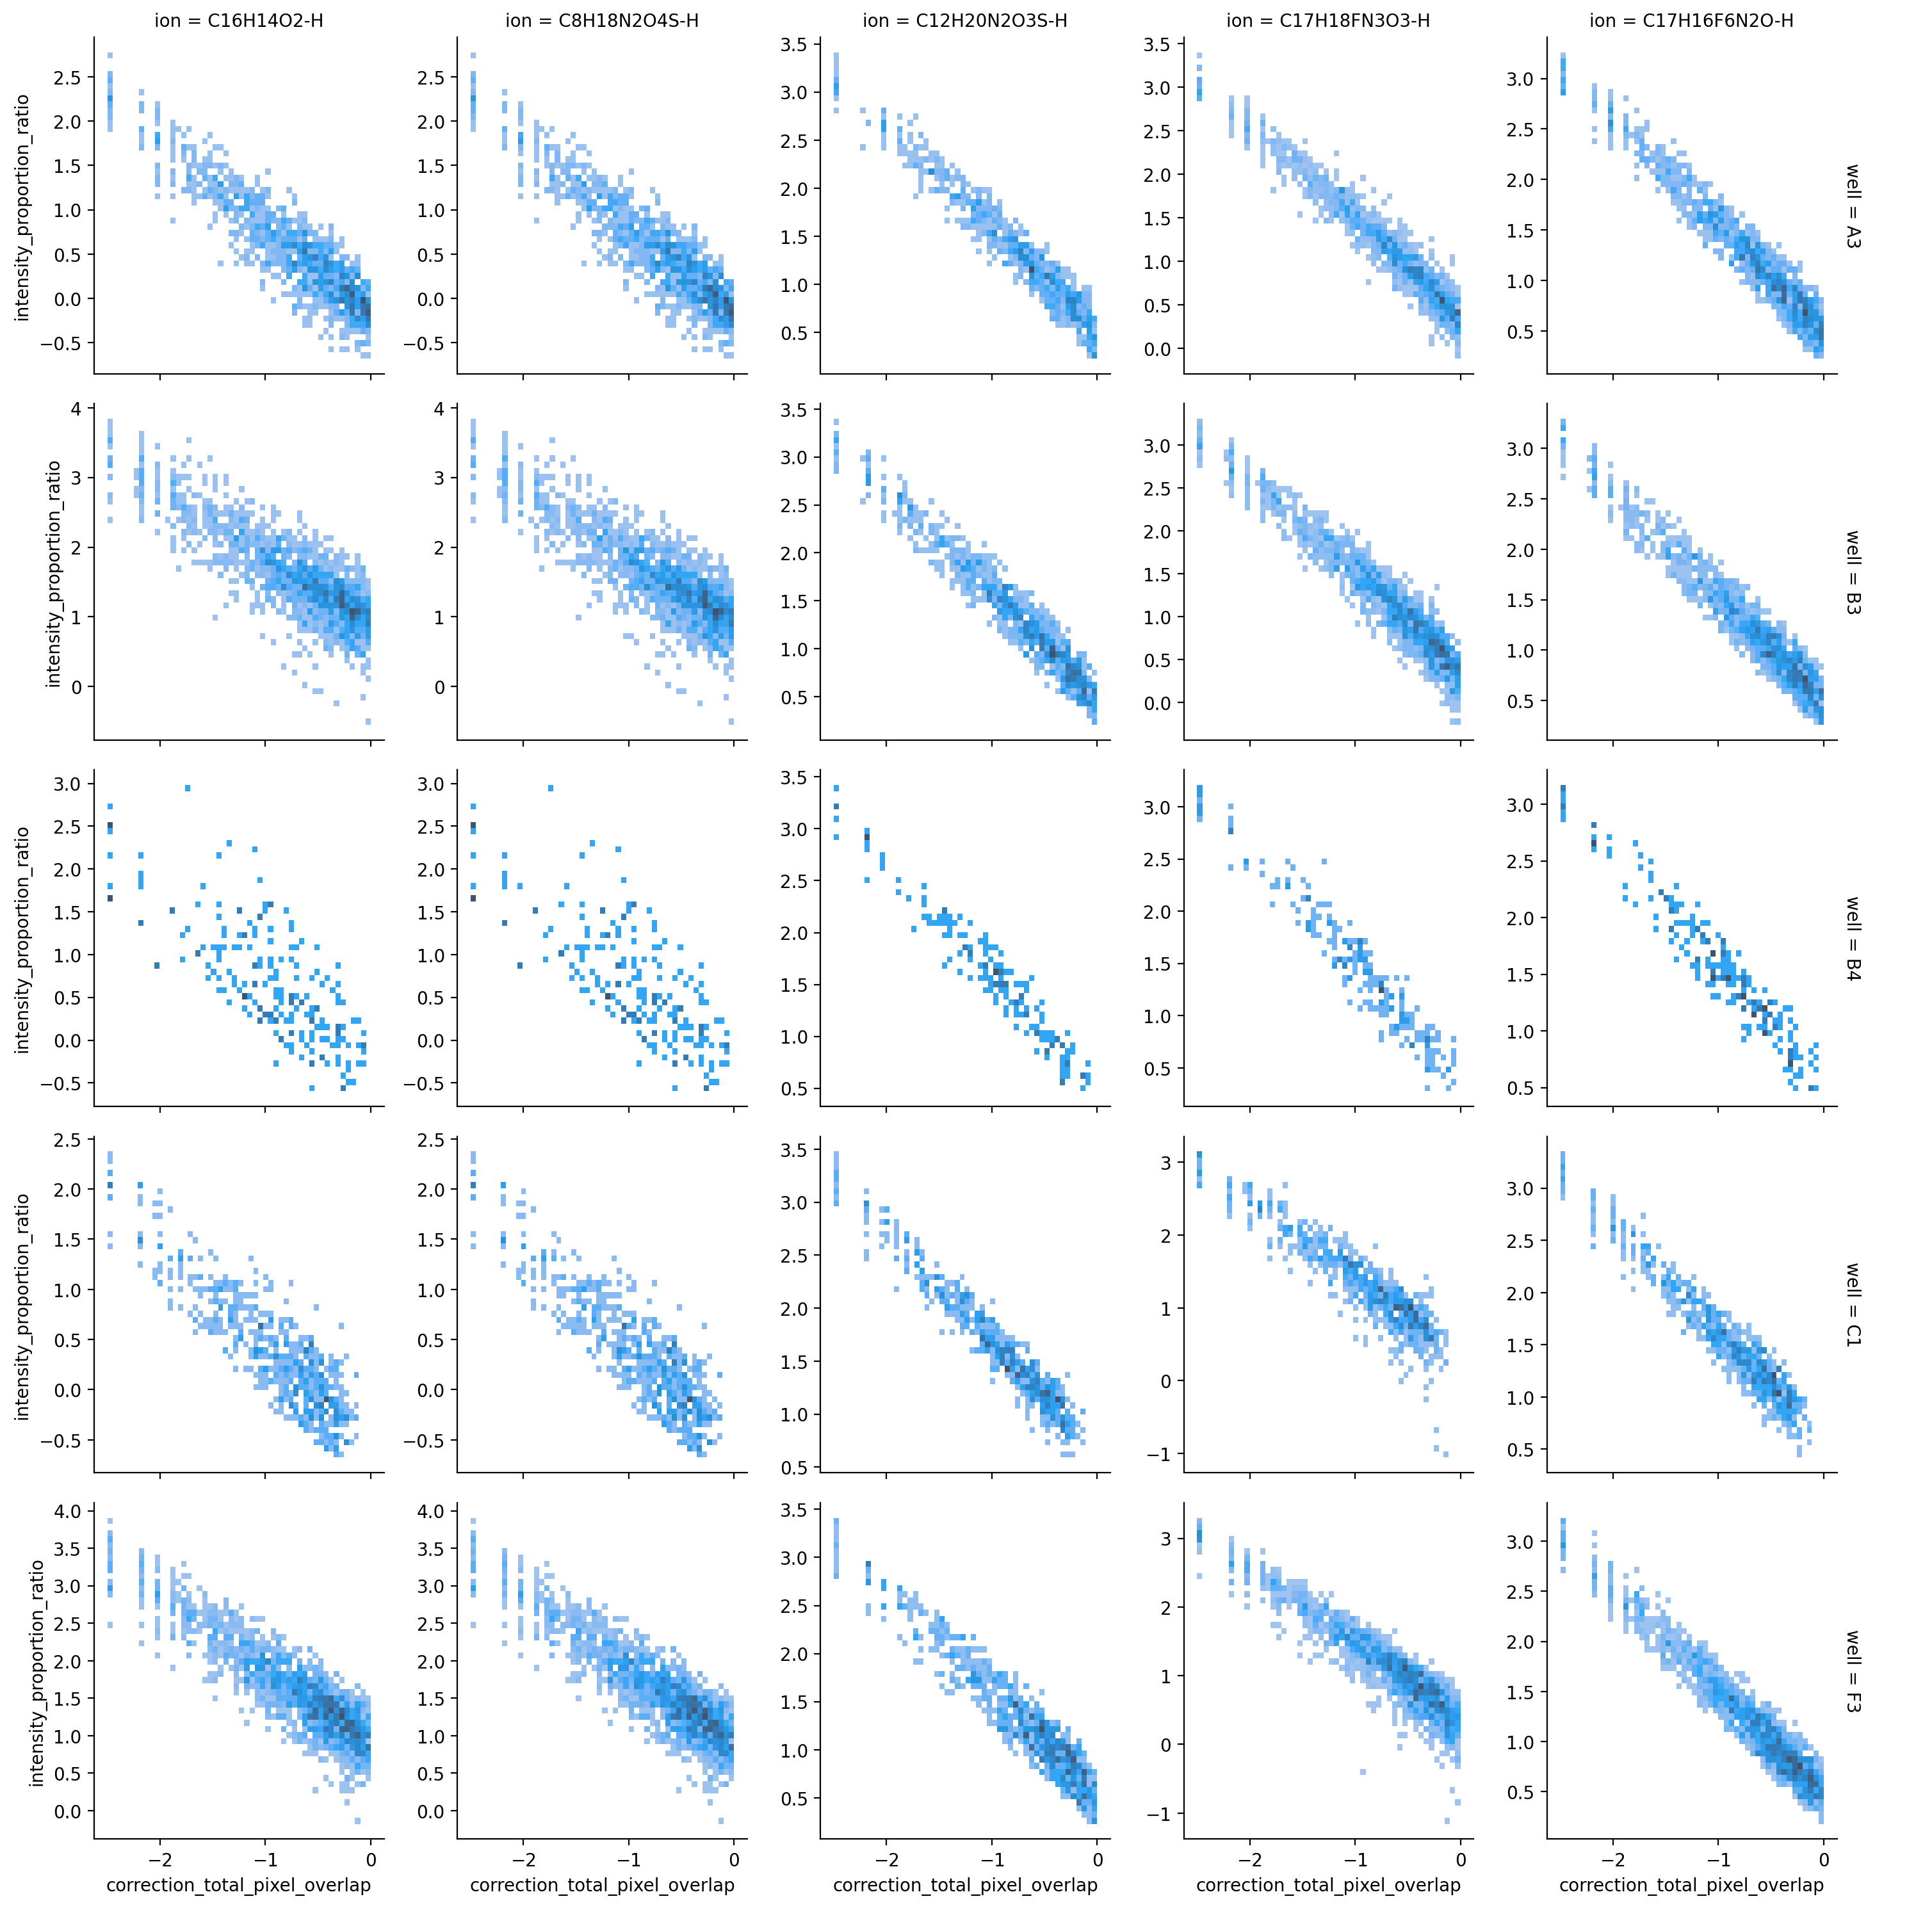

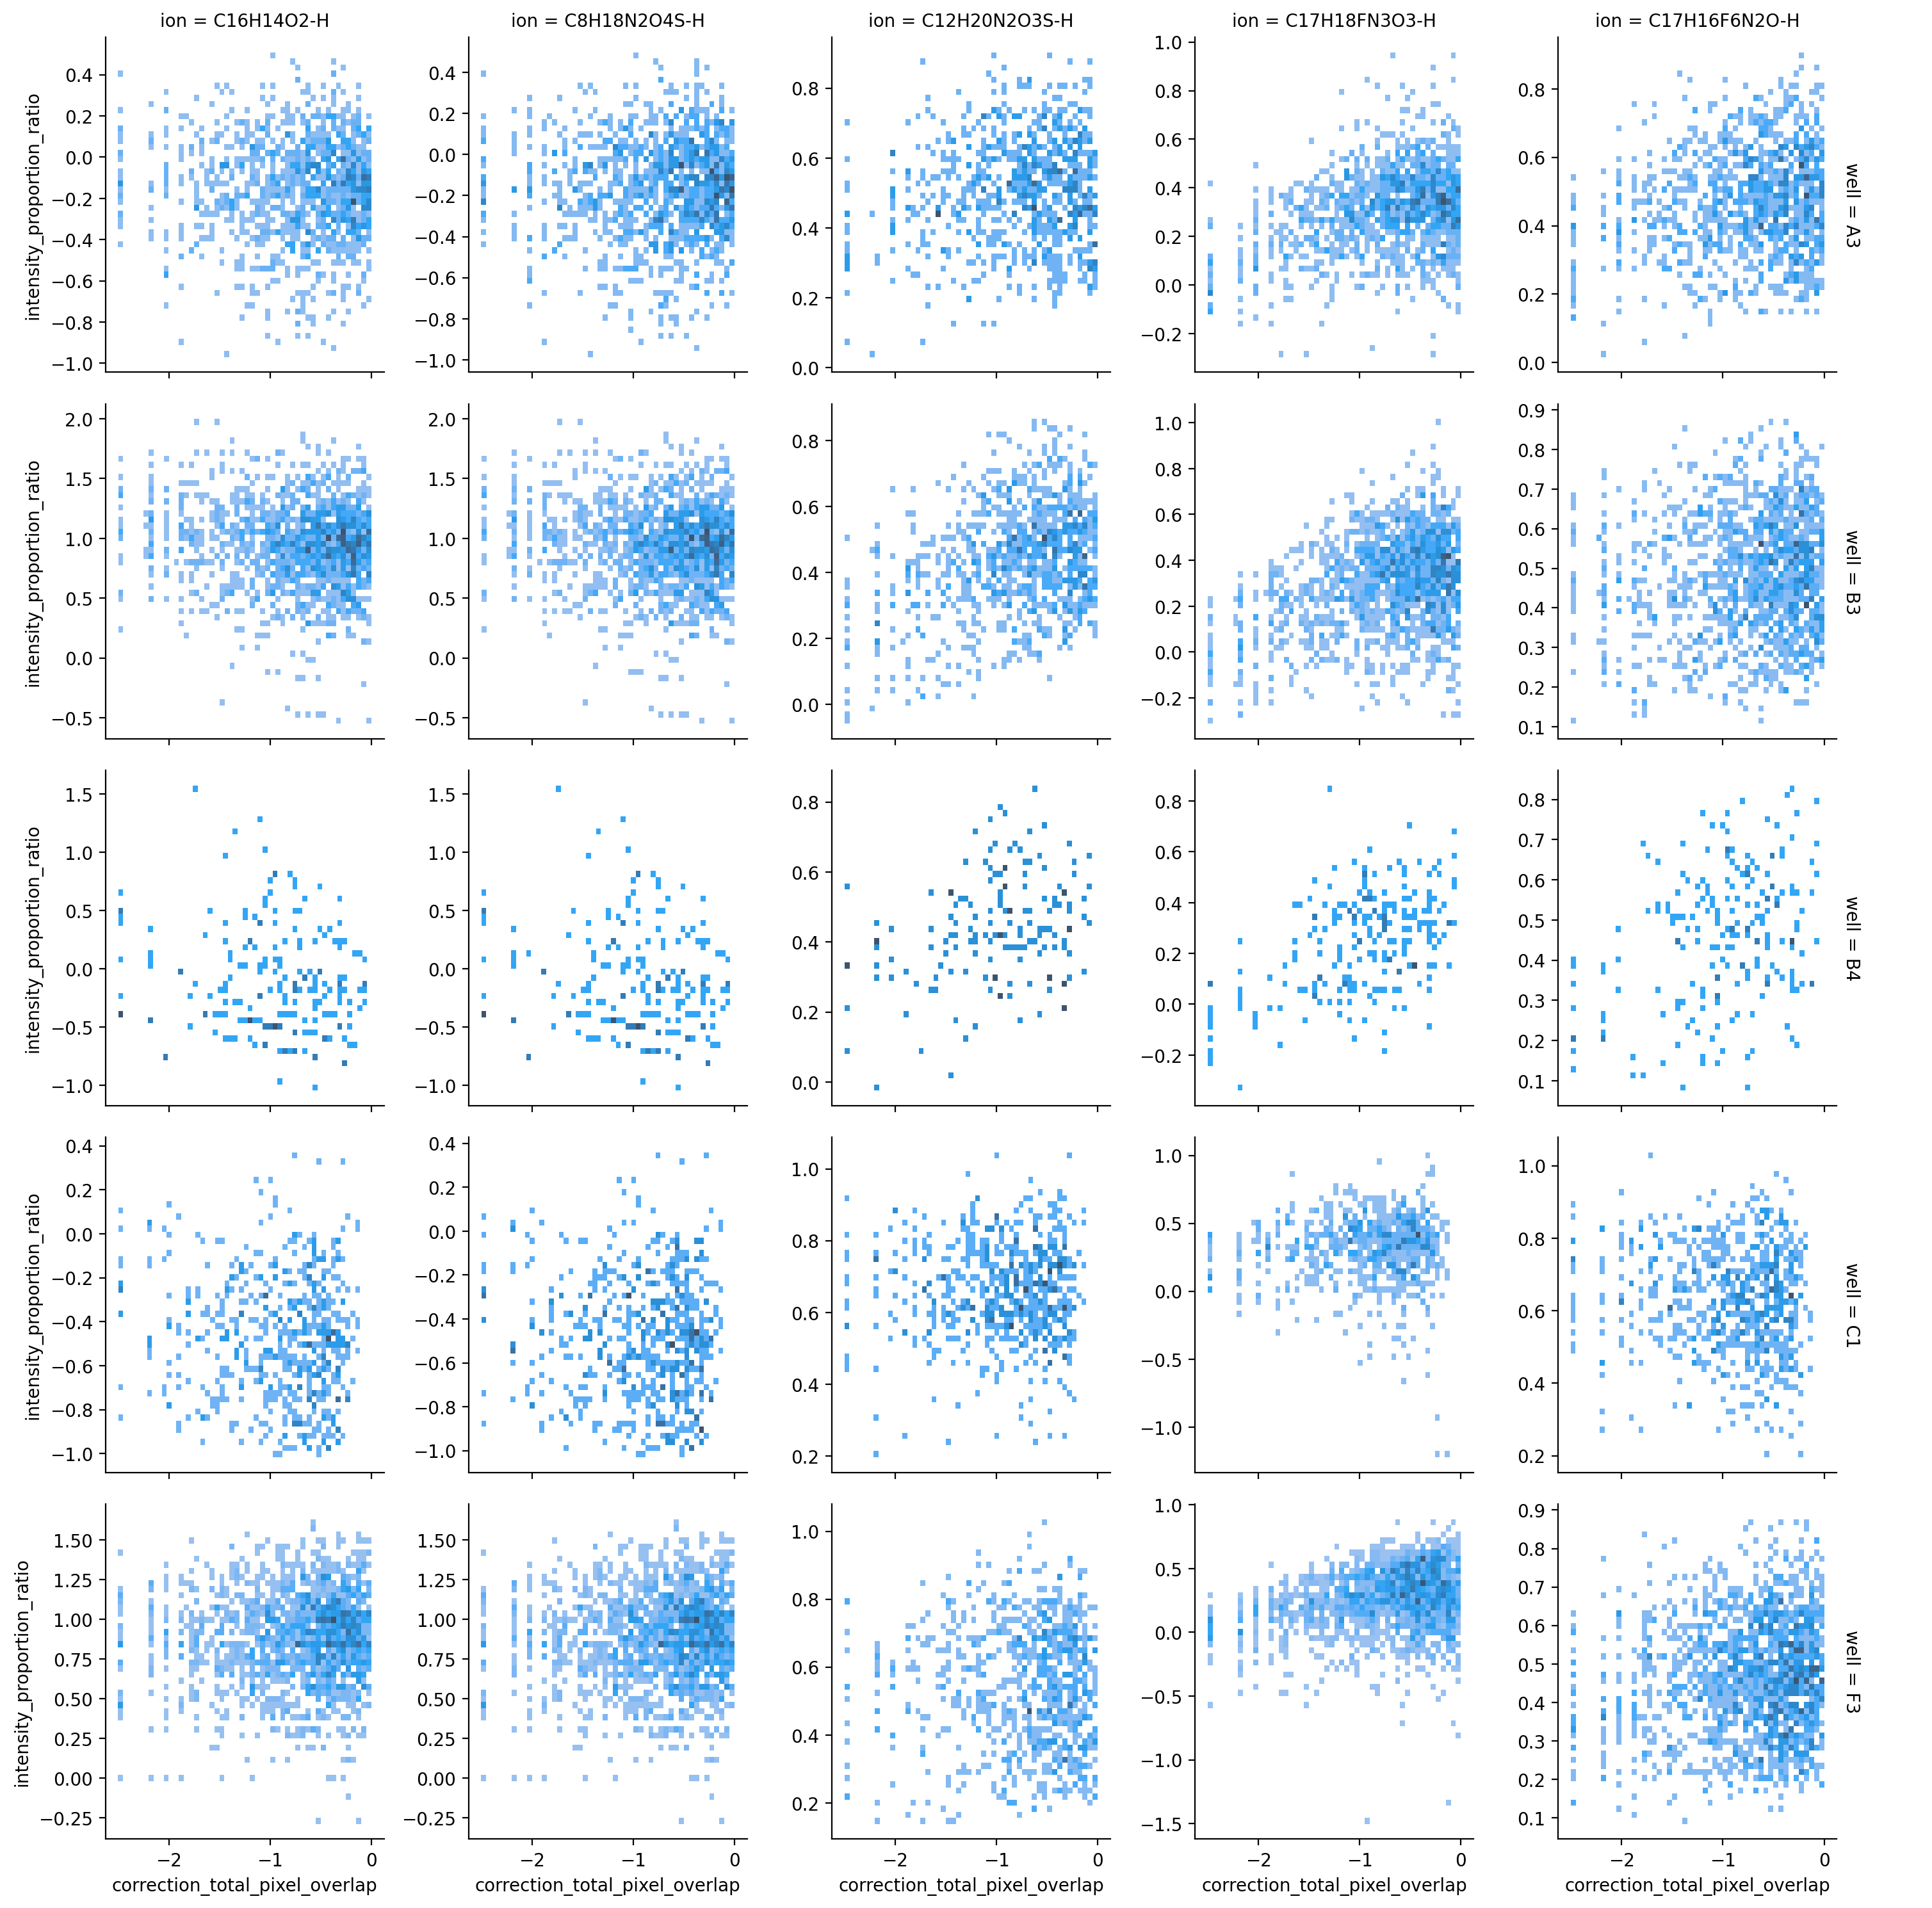

In [12]:
compare_pre_post_correction(am_adata, am_adata_cor)